In [2]:
%matplotlib inline



# Decoding source space data


Decoding to MEG data in source space on the left cortical surface. Here
univariate feature selection is employed for speed purposes to confine the
classification to a small number of potentially relevant features. The
classifier then is trained to selected features of epochs in source space.


In [8]:
# Author: Denis A. Engemann <denis.engemann@gmail.com>
#         Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Jean-Remi King <jeanremi.king@gmail.com>
#         Eric Larson <larson.eric.d@gmail.com>
#
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

import mne
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.decoding import (cross_val_multiscore, LinearModel, SlidingEstimator,
                          get_coef)

print(__doc__)

data_path = mne.datasets.sample.data_path()
fname_fwd = data_path + 'MEG/sample/sample_audvis-meg-oct-6-fwd.fif'
fname_evoked = data_path + '/MEG/sample/sample_audvis-ave.fif'
subjects_dir = data_path + '/subjects'

Automatically created module for IPython interactive environment


Set parameters



In [9]:
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
fname_cov = data_path + '/MEG/sample/sample_audvis-cov.fif'
fname_inv = data_path + '/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif'

tmin, tmax = -0.2, 0.8
event_id = dict(aud_r=2, vis_r=4)  # load contra-lateral conditions

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.filter(None, 10., fir_design='firwin')
events = mne.read_events(event_fname)

# Set up pick list: MEG - bad channels (modify to your needs)
raw.info['bads'] += ['MEG 2443']  # mark bads
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=True, eog=True,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=(None, 0), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6),
                    decim=5)  # decimate to save memory and increase speed

Opening raw data file /Users/ilamiheev/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 199 samples (1.325 sec)

143 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP o

Compute inverse solution



In [10]:
snr = 3.0
noise_cov = mne.read_cov(fname_cov)
inverse_operator = read_inverse_operator(fname_inv)

stcs = apply_inverse_epochs(epochs, inverse_operator,
                            lambda2=1.0 / snr ** 2, verbose=False,
                            method="dSPM", pick_ori="normal")

    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading inverse operator decomposition from /Users/ilamiheev/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did no

Decoding in sensor space using a logistic regression



[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


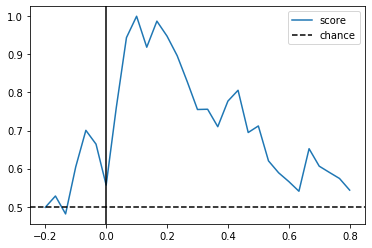

In [12]:
# Retrieve source space data into an array
X = np.array([stc.lh_data for stc in stcs])  # only keep left hemisphere
y = epochs.events[:, 2]

# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k=500),  # select features for speed
                    LinearModel(LogisticRegression(C=1, solver='liblinear')))
time_decod = SlidingEstimator(clf, scoring='roc_auc')

# Run cross-validated decoding analyses:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(epochs.times, scores.mean(0), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()

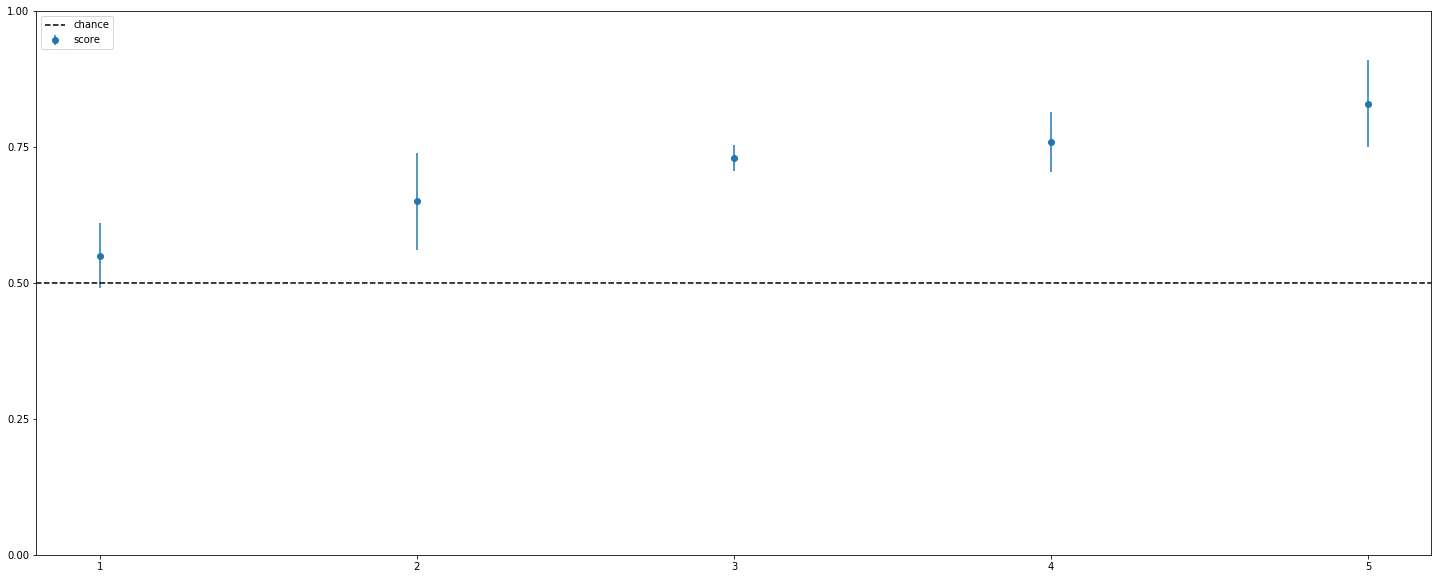

In [45]:
fig, ax = plt.subplots(1,figsize=(25,10) )
#ax.plot((1,2,3,4,5), (0.55,0.65,0.73,0.76,0.83),'o', label='score')
ax.axhline(0.5, color='k', linestyle='--', label='chance')
ax.errorbar((1,2,3,4,5), (0.55,0.65,0.73,0.76,0.83), yerr=(0.06,0.09,0.024,0.055,0.08),fmt='o',label='score' )
plt.xticks([1,2,3,4,5])
plt.yticks([0,0.25,0.5,0.75,1])
plt.legend(loc='upper left')


To investigate weights, we need to retrieve the patterns of a fitted model



In [42]:
# The fitting needs not be cross validated because the weights are based on
# the training sets
time_decod.fit(X, y)

# Retrieve patterns after inversing the z-score normalization step:
patterns = get_coef(time_decod, 'patterns_', inverse_transform=True)

stc = stcs[0]  # for convenience, lookup parameters from first stc
vertices = [stc.lh_vertno, np.array([], int)]  # empty array for right hemi
stc_feat = mne.SourceEstimate(np.abs(patterns), vertices=vertices,
                              tmin=stc.tmin, tstep=stc.tstep, subject='sample')

brain = stc_feat.plot(views=['lat'], transparent=True, time_label= None, initial_time=0.7, time_unit='s',
                      subjects_dir=subjects_dir)

[........................................] 100.00% Fitting SlidingEstimator |  
Using control points [ 3.50724321  4.37721471 15.59502304]
